In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import oh_to_12pluslog, mu, get_velocity_profile, get_velocity_evolution, boxcarsmoothtrend
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [43]:
output = vice.output("../outputs/potential-well-deepening/gamma0p2-oscil-0p1-0p4Gyr-skew5-fine")

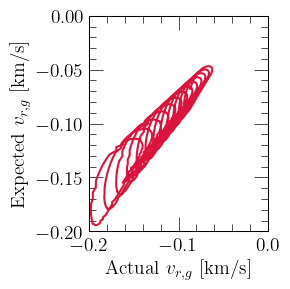

In [44]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Actual $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Expected $v_{r,g}$ [km/s]")
# ax.set_xlim([-10, 5])
ax.set_xlim([-0.2, 0])
ax.set_ylim(ax.get_xlim())
# ax.set_xscale("log")
# ax.set_yscale("log")

def plot_comparison(output, start = 5, radius = 8, zone_width = 0.1, gamma = 0.2, **kwargs):
    zone = output.zones["zone%d" % (int(radius / zone_width))]
    diff = [abs(_ - start) for _ in zone.history["lookback"]]
    idx = diff.index(min(diff))
    expected = []
    lookback = zone.history["lookback"][idx:]
    for i in range(idx, len(zone.history["time"])):
        mstar_now = 0
        mstar_next = 0
        if i < len(zone.history["time"]) - 1:
            for j in range(len(output.zones.keys())):
                mstar_now += output.zones["zone%d" % (j)].history["mstar"][i]
                mstar_next += output.zones["zone%d" % (j)].history["mstar"][i + 1]
            dt = zone.history["time"][i + 1] - zone.history["time"][i]
            expected.append(-radius * gamma * (mstar_next - mstar_now) / (mstar_now * dt))
        else:
            expected.append(expected[-1])
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    diff = [abs(_ - start) for _ in lookback]
    idx = diff.index(min(diff))
    vgas = vgas[idx:]
    ax.plot(vgas, expected, **kwargs)

plot_comparison(output, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [2]:
# output = vice.output("../outputs/linear/dvdr-0p1")
outputs = [
    # "../outputs/constant/vgas-0",
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/potential-well-deepening/gamma0p3"
]
outputs = [vice.output(name) for name in outputs]

In [2]:
def mendezdelgado2022_profile():
    radii = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
#     oh = [np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) /
#                    vice.solar_z['o']) - 0.059 * r for r in radii]
    log_oh_plus12 = [9.22 - 0.059 * r for r in radii]
    return [radii, log_oh_plus12]

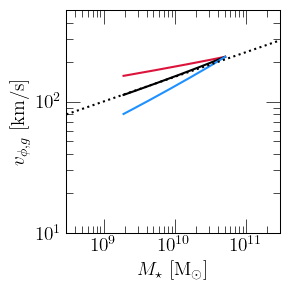

In [7]:
COLORS = ["crimson", "black", "dodgerblue"]
GAMMAS = [0.1, 0.2, 0.3]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$M_\star$ [M$_\odot$]")
ax.set_ylabel(r"$v_{\phi,g}$ [km/s]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([3.e8, 3.e11])
ax.set_ylim([10, 500])

def plot_model(output, zone_width = 0.1, **kwargs):
    _radius = 8
    _vphitoday = 220
    lookback, vrad = get_velocity_evolution(output, _radius, zone_width = zone_width)
    lookback = lookback[::-1]
    vrad = vrad[::-1]
    n_zones = len(output.zones.keys())
    mstar = []
    for i in range(len(lookback)):
        m = 0
        for j in range(n_zones):
            m += output.zones["zone%d" % (j)].history["mstar"][-1 - i]
        mstar.append(m)
    vphi = [_vphitoday]
    dt = lookback[1] - lookback[0]
    for i in range(len(lookback) - 1):
        # v = vphi[i] * (1 - vrad[i] / _radius * dt)
        # vphi.append(v)
        dlnvphi = vrad[i] / _radius * dt
        # print(dt)
        # print("====")
        # print(vrad[i])
        # print(dt)
        # print(dlnvphi)
        # if i > 5: break
        vphi.append(vphi[i] * (1 + dlnvphi))
    # print(list(zip(mstar, vphi)))
    # vphi = [_vphitoday]
    # dt = output.zones["zone0"].history["time"][1] - output.zones["zone0"].history["time"][0]
    # for i in range(len(lookback))[::-1]:
    #     v = vphi[-1 - i] * vrad[-1 - i] / _radius * dt
    #     vphi.prepend(v)
    ax.plot(mstar, vphi, **kwargs)

for i in range(len(outputs)):
# for i in [0]:
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$\gamma = %g$" % (GAMMAS[i])
    }
    plot_model(outputs[i], **kwargs)

xvals = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), 100)
yvals = [10**0.31 * m**0.188 for m in xvals]
ax.plot(xvals, yvals, c = named_colors()["black"], linestyle = ":")

plt.tight_layout()
plt.show()

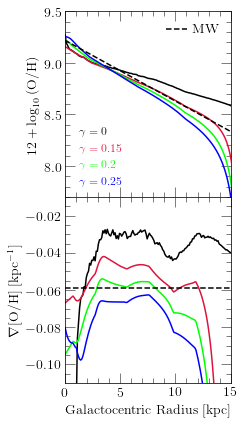

In [22]:
COLORS = ["black", "crimson", "lime", "blue"]
# LABELS = [r"$\dot L_\text{dyn} / L = %g$ Gyr$^{-1}$" % (_) for _ in [0, -0.05, -0.1, -0.15]]
# LABELS = [r"$%g$ Gyr$^{-1}$" % (_) for _ in [0, -0.02, -0.05, -0.08]]
LABELS = [r"$\gamma = %g$" % (_) for _ in [0, 0.15, 0.2, 0.25]]

fig = plt.figure(figsize = (3.5, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
ax1.set_ylabel(r"$12 + \log_{10}\text{(O/H)}$")
# ax1.set_ylabel(r"[O/H]$_\text{ISM}$")
ax2.set_ylabel(r"$\nabla$[O/H] [kpc$^{-1}$]")
ax1.set_xlim([0, 15])
# ax1.set_ylim([-0.7, 0.7])
ax1.set_ylim([7.7, 9.5])
ax2.set_ylim([-0.11, -0.01])
# ax1.set_yticks([-0.5, 0, 0.5])
ax2.set_yticks([-0.1, -0.08, -0.06, -0.04, -0.02])

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--",
    "zorder": 1000,
    "label": "MW"
}
radii, logohplus12 = mendezdelgado2022_profile()
line1 = ax1.plot(radii, logohplus12, **kwargs)[0]
line2 = ax2.axhline(-0.059, **kwargs)
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5
}
leg = ax1.legend(**kwargs)
ax1.add_artist(leg)
line1.set_label(None)
line2.set_label(None)

def plot_prediction(output, zone_width = 0.1, **kwargs):
#     radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    radii = [zone_width * (i + 0.5) for i in range(int(15.5 / zone_width))]
    oh = []
    dohdr = []
    for i in range(len(radii)):
        oh.append(output.zones["zone%d" % (i)].history["[o/h]"][-1])
    oh = [oh_to_12pluslog(_) for _ in oh]
    for i in range(len(radii) - 1):
        dohdr.append((oh[i + 1] - oh[i]) / (radii[i + 1] - radii[i]))
    ax1.plot(radii, oh, **kwargs)
    dohdr = boxcarsmoothtrend(radii[:-1], dohdr, window = 10)
    ax2.plot(radii[:-1], dohdr, **kwargs)

# plot_prediction(output, c = named_colors()["black"])
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_prediction(outputs[i], **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 12
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./potential-well-deepening/presentday-oh-profiles-gradients.%s" % (ext), **kwargs)
plt.show()

In [4]:
output = vice.output("../outputs/potential-well-deepening/gamma0p2-taustarconst")
# output = vice.output("../outputs/potential-well-deepening/gamma0p2")
# output = vice.output("../outputs/constant/vgas-0")

/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  mu *= -tau_star * vgas[i]
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_96474/4076704859.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

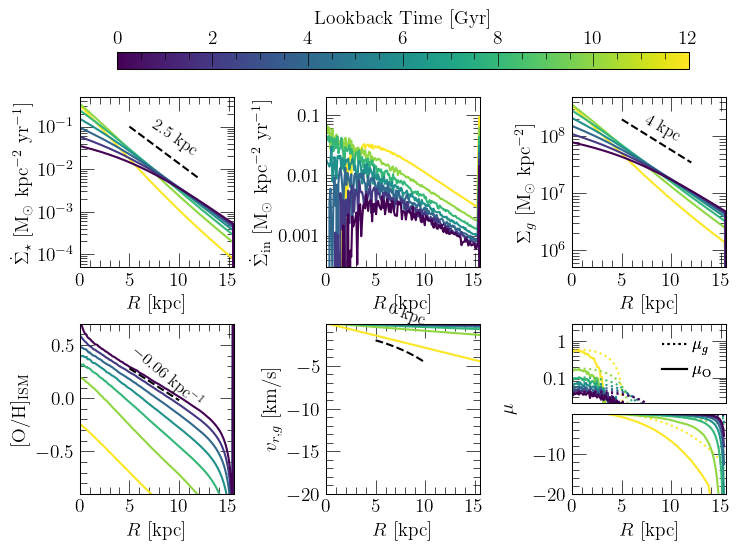

In [5]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
# COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet", "black"]
COLORMAP = "viridis"
XLIM = 6 * [[0, 15.5]]
YLIM = [[5.e-5, 0.5], [3.e-4, 0.2], [5.e5, 5.e8], [-0.9, 0.7], [0.05, 20], [0.02, 3], [0.2, 20]]

fig = plt.figure(figsize = (7.5, 5.6))
axes = 6 * [None]
for i in range(6):
    axes[i] = fig.add_subplot(231 + i)
    if i != 5: axes[i].set_xlabel(r"$R$ [kpc]", fontsize = 14)
    if i < 3: axes[i].set_yscale("log")
    axes[i].set_xlim(XLIM[i])
    axes[i].set_xticks([0, 5, 10, 15])
    axes[i].set_ylim(YLIM[i])
axes[-1].set_yscale("log")
axes[-1].yaxis.set_major_formatter(fsf("%g"))
axes[1].yaxis.set_major_formatter(fsf("%g"))
axes[0].set_ylabel(r"$\dot\Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 14)
axes[1].set_ylabel(r"$\dot\Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 14)
axes[2].set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]", fontsize = 14)
axes[3].set_ylabel(r"[O/H]$_\text{ISM}$")
axes[4].set_ylabel(r"$v_{r,g}$ [km/s]")

bottom = fig.add_axes([0.8, 0.8, 0.1, 0.1], sharex = axes[-1])
plt.setp(axes[-1].get_xticklabels(), visible = False)
bottom.set_xlabel(r"$R$ [kpc]")
bottom.set_ylim(YLIM[-1])
dummy = fig.add_axes([0.8, 0.8, 0.1, 0.1], xticks = [], yticks = [], zorder = -1000)
dummy.spines["left"].set_visible(False)
dummy.spines["right"].set_visible(False)
dummy.set_ylabel(r"$\mu$", labelpad = 40)
axes[-1].tick_params(axis = "x", which = "both", bottom = False)
bottom.tick_params(axis = "x", which = "both", top = False)

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_sfr = []
    sigma_in = []
    sigma_gas = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_in.append(zone.history["ifr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    axes[0].plot(radii, sigma_sfr, **kwargs)
    axes[1].plot(radii, sigma_in, **kwargs)
    axes[2].plot(radii, sigma_gas, **kwargs)

    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, vgas = get_velocity_profile(output, lookback)
        _, mu_gas, mu_oxygen = mu(output, lookback)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        vgas = len(radii) * [0.]
        mu_gas = mu_oxygen = vgas[:-1]
    oh_ism = []
    for i in range(len(radii)):
        oh_ism.append(output.zones["zone%d" % (i)].history["[o/h]"][idx])
    axes[3].plot(radii, oh_ism, **kwargs)
    axes[4].plot(radii, [-v for v in vgas], **kwargs)
    axes[5].plot(radii[:-1], mu_oxygen, **kwargs)
    axes[5].plot(radii[:-1], mu_gas, linestyle = ":", **kwargs)
    bottom.plot(radii[:-1], [-mu for mu in mu_oxygen], **kwargs)
    bottom.plot(radii[:-1], [-mu for mu in mu_gas], linestyle = ":", **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i]),
        # "label": "%g Gyr ago" % (LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)

cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]")
cbar.ax.xaxis.set_ticks_position("top") # location = "top" keyword in later version of matplotlib
cbar.ax.xaxis.set_label_position("top")

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--"
}
fs = 12
xvals = np.linspace(5, 12, 100)
yvals = [0.1 * np.exp(-(x - xvals[0]) / 2.5) for x in xvals]
axes[0].plot(xvals, yvals, **kwargs)
axes[0].text(7, 0.02, r"2.5 kpc", fontsize = fs, rotation = -35)

yvals = [2.e8 * np.exp(-(x - xvals[0]) / 4) for x in xvals]
axes[2].plot(xvals, yvals, **kwargs)
axes[2].text(7, 8e7, r"4 kpc", fontsize = fs, rotation = -30)

xvals = np.linspace(5, 10, 100)
yvals = [-0.06 * (x - 8) + 0.1 for x in xvals]
axes[3].plot(xvals, yvals, **kwargs)
axes[3].text(5, -0.1, r"$-0.06$ kpc$^{-1}$", fontsize = fs, rotation = -40)

yvals = [2 * np.exp((x - xvals[0]) / 6) for x in xvals]
axes[4].plot(xvals, yvals, **kwargs)
axes[4].text(6, 0.3, r"6 kpc", fontsize = fs, rotation = -20)

kwargs = {
    "c": named_colors()["black"]
}
lines = []
lines.append(axes[-1].plot([0, 1], [11, 12], linestyle = ":", label = r"$\mu_g$", **kwargs)[0])
lines.append(axes[-1].plot([0, 1], [11, 12], linestyle = "-", label = r"$\mu_\text{O}$", **kwargs)[0])
kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 12,
    "handlelength": 1.5,
    # "bbox_to_anchor": (1, 0)
}
leg = axes[-1].legend(**kwargs)
axes[-1].add_artist(leg)
lines[0].remove()
lines[1].remove()

plt.tight_layout()
axes[-2].yaxis.set_major_formatter(fsf("%g"))
bottom.yaxis.set_major_formatter(fsf("%g"))
negative_log(axes[-2])
negative_log(bottom)
# axes[-2].set_yscale("log")
# bottom.set_yscale("log")
plt.subplots_adjust(top = 0.82, wspace = 0.6)
mu_split = 0.01
cbar_ax.set_position([
    axes[0].get_position().x0 + 0.05,
    axes[0].get_position().y1 + 0.05,
    axes[2].get_position().x1 - axes[0].get_position().x0 - 0.1,
    0.03
])
axes[-1].set_position([
    axes[-1].get_position().x0,
    (axes[-2].get_position().y0 + axes[-2].get_position().y1) / 2 + mu_split,
    axes[-1].get_position().x1 - axes[-1].get_position().x0,
    (axes[-2].get_position().y1 - axes[-2].get_position().y0) / 2 - mu_split
])
bottom.set_position([
    axes[-1].get_position().x0,
    axes[-2].get_position().y0,
    axes[-1].get_position().x1 - axes[-1].get_position().x0,
    (axes[-2].get_position().y1 - axes[-2].get_position().y0) / 2 - mu_split
])
dummy.set_position([
    bottom.get_position().x0,
    bottom.get_position().y0,
    bottom.get_position().x1 - bottom.get_position().x0,
    axes[-1].get_position().y1 - bottom.get_position().y0
])
# for ext in ["pdf", "jpeg"]:
    # kwargs = {}
    # if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./potential-well-deepening/gamma0p2.%s" % (ext), **kwargs)
plt.show()